# Imports

In [184]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import CLIPTokenizer, CLIPModel
from sentence_transformers import SentenceTransformer
import Levenshtein
import numpy as np
import torch

# Load data

In [185]:
with open('../data/pwc/methods.json', 'r') as f:
    methods_data = json.load(f)

In [186]:
methods_data[0]

{'url': 'https://paperswithcode.com/method/sig',
 'name': 'SIG',
 'full_name': 'Sliced Iterative Generator',
 'description': 'The **Sliced Iterative Generator (SIG)** is an iterative generative model that is a Normalizing Flow (NF), but shares the advantages of Generative Adversarial Networks (GANs). The model is based on iterative Optimal Transport of a series of 1D slices through the data space, matching on each slice the probability distribution function (PDF) of the samples to the data. To improve the efficiency, the directions of the orthogonal slices are chosen to maximize the PDF difference between the generated samples and the data using Wasserstein distance at each iteration. A patch based approach is adopted to model the images in a hierarchical way, enabling the model to scale well to high dimensions. \r\n\r\nUnlike GANs, SIG has a NF structure and allows efficient likelihood evaluations that can be used in downstream tasks. While SIG has a deep neural network architecture, 

# Filter data

For the analysis I use the 'name' and 'description' of the mathods that belong to exactly one collection and that collection is not 'General'

In [187]:
flat_data = []
for item in methods_data:
    if len(item["collections"]) == 1:
        area = item["collections"][0]["area"]
        if area != 'General':
            flat_data.append({
                "name": item["name"],
                "description": item["description"],
                "area": area
            })

In [188]:
len(flat_data)

1064

In [189]:
df = pd.DataFrame(flat_data)

This is the final amount of data left after filtering

In [190]:
df['area'].value_counts()

area
Computer Vision                665
Natural Language Processing    119
Graphs                         104
Reinforcement Learning          88
Sequential                      53
Audio                           35
Name: count, dtype: int64

# Define the embeddings

TF-IDF

In [191]:
def compute_tfidf(text_list):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=3000, sublinear_tf=True)
    vectors = vectorizer.fit_transform(text_list)
    return vectors.toarray()

Sentence-BERT embedding

In [192]:
model_bert = SentenceTransformer('all-MiniLM-L6-v2')

def compute_sentence_embeddings(text_list, batch_size=256):
    embeddings = []
    text_list = [text.strip() for text in text_list]

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        batch_embeddings = model_bert.encode(batch)
        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings
    return np.vstack(embeddings)

/home/jenifer/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



OpenAI CLIP embedding

In [193]:
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_embeddings(text_list, batch_size=256):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            batch_embeddings = model_clip.get_text_features(**inputs).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Calculate the embeddings

In [194]:
names = df['name'].tolist()
descriptions = df['description'].tolist()

In [195]:
names_tfidf = compute_tfidf(names)
descriptions_tfidf = compute_tfidf(descriptions)


In [196]:
sentence_embeddings_names = compute_sentence_embeddings(names)
sentence_embeddings_descriptions = compute_sentence_embeddings(descriptions)

In [197]:
clip_embeddings_names = compute_clip_embeddings(names)
clip_embeddings_descriptions = compute_clip_embeddings(descriptions)

# Reduce dimensionality for the plot

In [198]:
def reduce_dimensionality(embeddings, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(embeddings)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(embeddings)
    return reduced

In [199]:
reduced_names_tfids = reduce_dimensionality(names_tfidf, method='tsne')
reduced_descriptions_tfidf = reduce_dimensionality(descriptions_tfidf, method='tsne')

In [200]:
reduced_embeddings_names = reduce_dimensionality(sentence_embeddings_names, method='tsne')
reduced_embeddings_descriptions = reduce_dimensionality(sentence_embeddings_descriptions, method='tsne')

In [201]:
reduced_clip_names = reduce_dimensionality(clip_embeddings_names, method='tsne')
reduced_clip_descriptions = reduce_dimensionality(clip_embeddings_descriptions, method='tsne')

# Plot

In [202]:
def plot_embeddings(embeddings, color_by, title, color_map):
    plt.figure(figsize=(15, 5))
    # Convert color_by into a categorical type and get unique categories
    categories = pd.Categorical(color_by)
    category_codes = categories.codes
    category_labels = categories.categories
    # Create scatter plot
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=category_codes, cmap=color_map, marker='.')
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    # Create a custom legend
    unique_categories = np.unique(category_codes)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(code)), markersize=10) for code in unique_categories]
    # Set ticks inside the plot and make them thicker
    plt.tick_params(axis='both', direction='in', which='both', width=1)
    
    filename = title.lower().replace(' ', '_')
    plt.legend(legend_elements, category_labels, title="Research area", loc="upper right")
    plt.savefig(f"../plots/rq1/{filename}.svg", format="svg")
    plt.savefig(f"../plots/rq1/{filename}.png", format="png", dpi=300)
    plt.savefig(f"../plots/rq1/{filename}.pdf", format="pdf")
    plt.show()

## Plot TF-IDF Embeddings

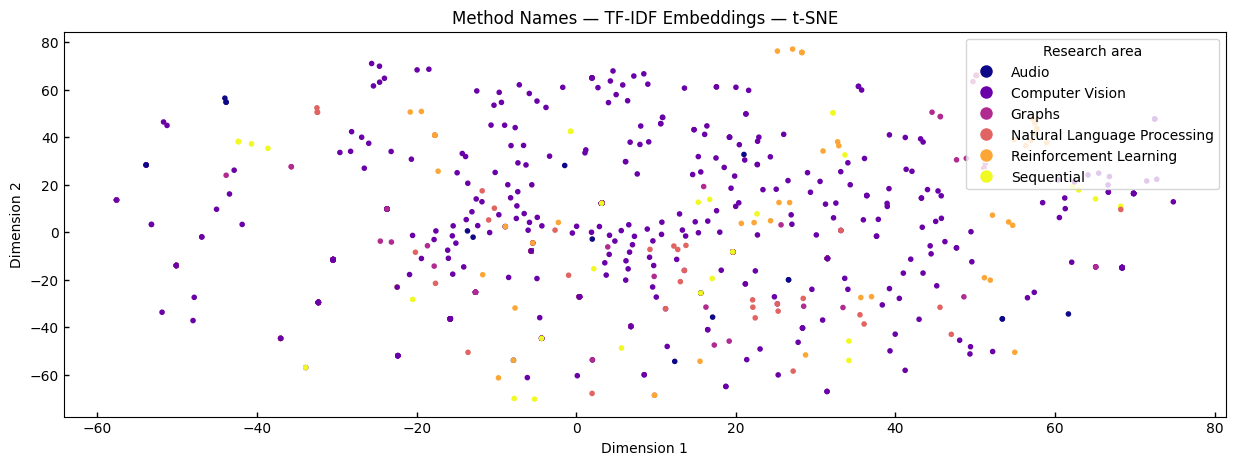

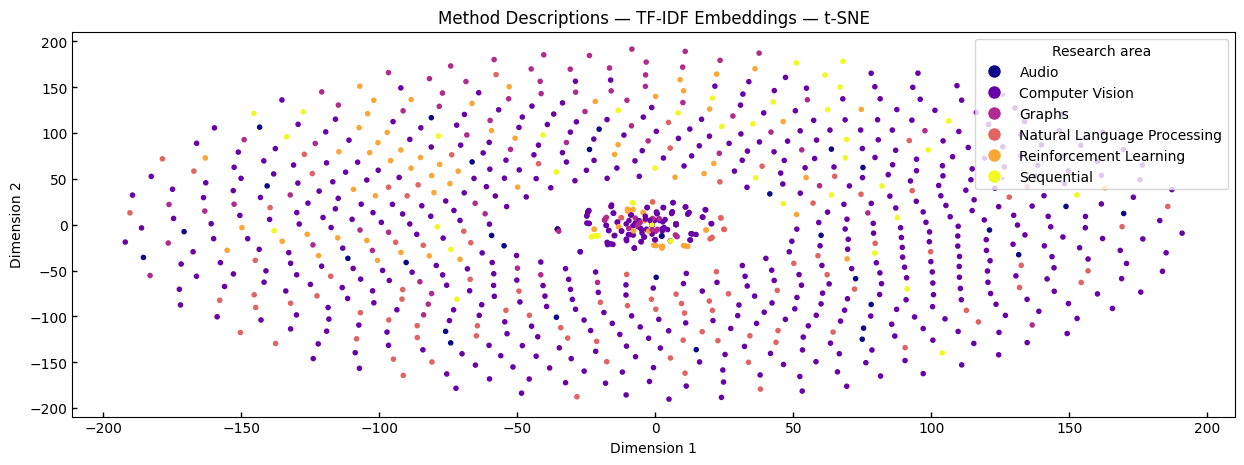

In [203]:
plot_embeddings(reduced_names_tfids, df['area'], 'Method Names — TF-IDF Embeddings — t-SNE', 'plasma')
plot_embeddings(reduced_descriptions_tfidf, df['area'], 'Method Descriptions — TF-IDF Embeddings — t-SNE', 'plasma')

## Plot Sentence-BERT Embeddings 

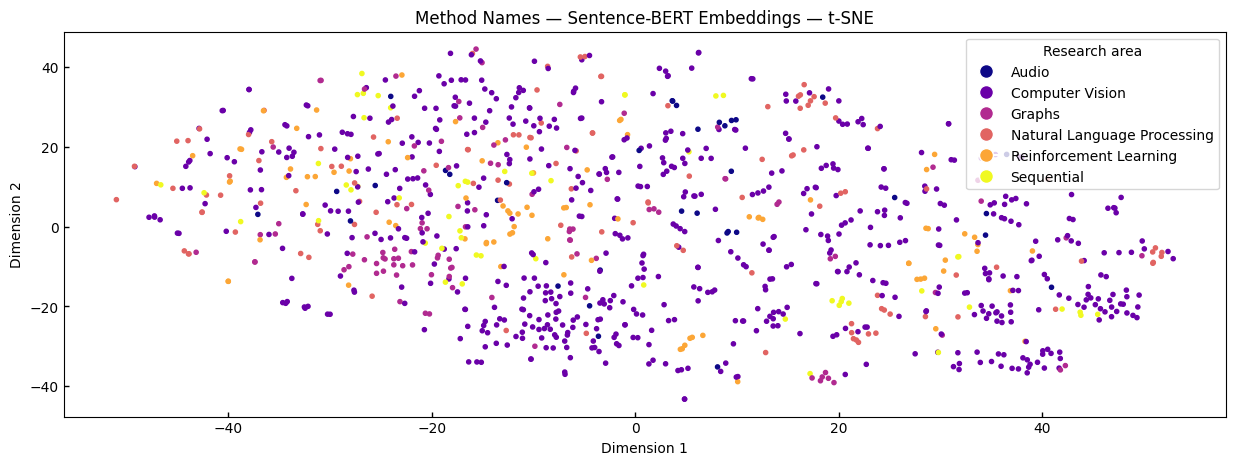

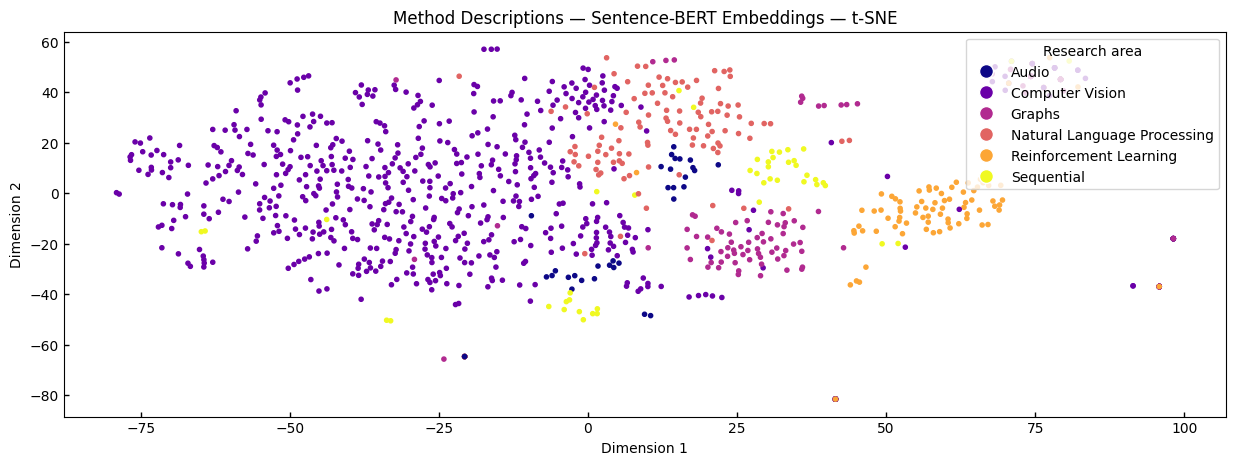

In [204]:
plot_embeddings(reduced_embeddings_names, df['area'], 'Method Names — Sentence-BERT Embeddings — t-SNE', 'plasma')
plot_embeddings(reduced_embeddings_descriptions, df['area'], 'Method Descriptions — Sentence-BERT Embeddings — t-SNE', 'plasma')

## Plot CLIP Embeddings

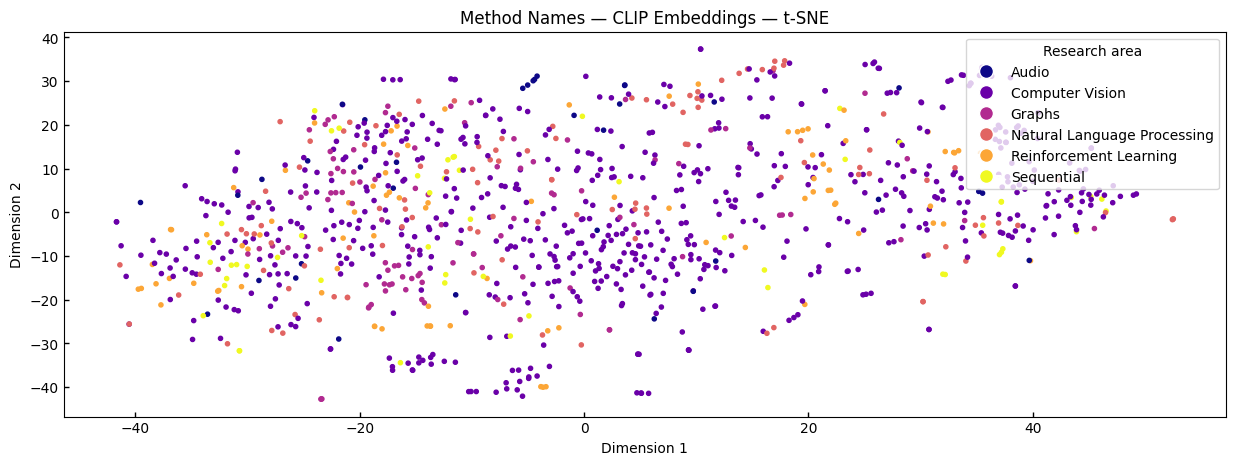

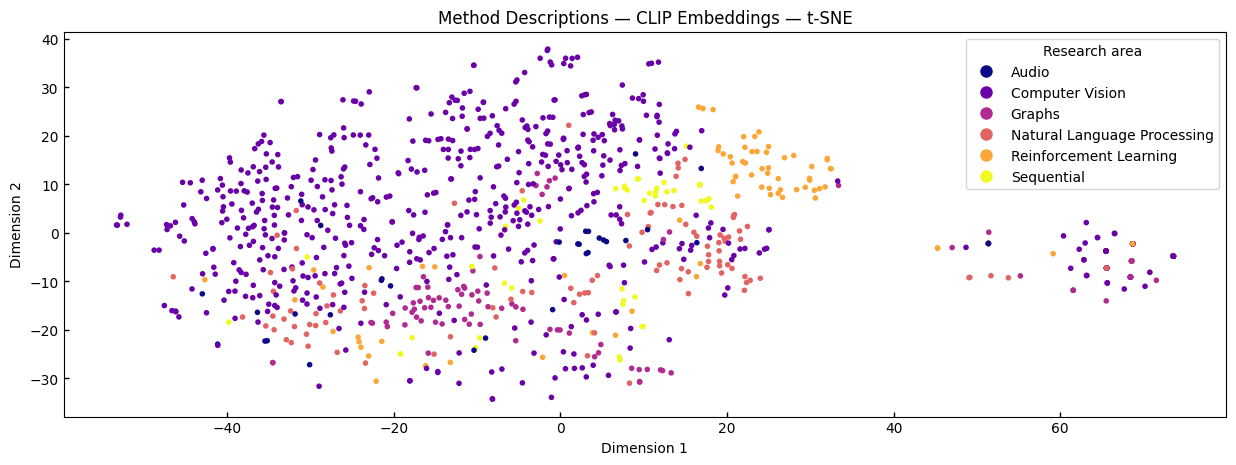

In [205]:
plot_embeddings(reduced_clip_names, df['area'], 'Method Names — CLIP Embeddings — t-SNE', 'plasma')
plot_embeddings(reduced_clip_descriptions, df['area'], 'Method Descriptions — CLIP Embeddings — t-SNE', 'plasma')

In [206]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [207]:
def evaluate_clustering_metrics(X, y, embedding_name, source_text):
    print(f'Clustering metrics for {embedding_name} - {source_text}:')
    # Calculate metrics
    silhouette_avg = silhouette_score(X, y)
    calinski_harabasz = calinski_harabasz_score(X, y)
    davies_bouldin = davies_bouldin_score(X, y)
    
    # Return results in a dictionary
    metrics = {
        'Silhouette Score': silhouette_avg,
        'Calinski-Harabasz Index': calinski_harabasz,
        'Davies-Bouldin Index': davies_bouldin
    }
    
    table = [["Metric", "Score"]]
    for metric, score in metrics.items():
        table.append([metric, f"{score:.4f}"])
    
    print(f'Clustering metrics for {embedding_name} - {source_text}:')
    print(f'Silhouette Score: {silhouette_avg:.4f}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')
    print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')



In [208]:
evaluate_clustering_metrics(reduced_names_tfids, df['area'], 'TF-IDF', 'Names')

Clustering metrics for TF-IDF - Names:
Clustering metrics for TF-IDF - Names:
Silhouette Score: -0.0998
Calinski-Harabasz Index: 2.1983
Davies-Bouldin Index: 25.1087


In [209]:
evaluate_clustering_metrics(reduced_descriptions_tfidf, df['area'], 'TF-IDF', 'Descriptions')

Clustering metrics for TF-IDF - Descriptions:
Clustering metrics for TF-IDF - Descriptions:
Silhouette Score: -0.1325
Calinski-Harabasz Index: 18.9289
Davies-Bouldin Index: 9.3969


In [210]:
evaluate_clustering_metrics(reduced_embeddings_names, df['area'], 'BERT', 'Names')

Clustering metrics for BERT - Names:
Clustering metrics for BERT - Names:
Silhouette Score: -0.1083
Calinski-Harabasz Index: 6.9565
Davies-Bouldin Index: 21.5425


In [211]:
evaluate_clustering_metrics(reduced_embeddings_descriptions, df['area'], 'BERT', 'Descriptions')

Clustering metrics for BERT - Descriptions:
Clustering metrics for BERT - Descriptions:
Silhouette Score: -0.0043
Calinski-Harabasz Index: 67.3682
Davies-Bouldin Index: 3.5635


In [212]:
evaluate_clustering_metrics(reduced_clip_names, df['area'], 'CLIP', 'Names')

Clustering metrics for CLIP - Names:
Clustering metrics for CLIP - Names:
Silhouette Score: -0.0997
Calinski-Harabasz Index: 6.3118
Davies-Bouldin Index: 10.6563


In [213]:
evaluate_clustering_metrics(reduced_clip_descriptions, df['area'], 'CLIP', 'Descriptions')

Clustering metrics for CLIP - Descriptions:
Clustering metrics for CLIP - Descriptions:
Silhouette Score: -0.0788
Calinski-Harabasz Index: 19.1802
Davies-Bouldin Index: 6.1514
